## Deep Learning using resnet50
- [building a deep learning model with keras and resnet50](https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351) 코드 참고
- 작물마다 훈련을 제각기 진행

### (1) Project Setup

In [43]:
# import
import tensorflow as tf
import numpy as np


from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50

from keras.preprocessing import image
from keras import layers

from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from keras.models import Model, Sequential

from keras.preprocessing import image

import pathlib
import fnmatch

In [44]:
# 로컬 데이터 경로 설정
root_data_dir = pathlib.Path("./separate-dataset/")

height,width= 180,180
training_batch_size= 32
validation_split = 0.2
seed = 123

### (2) Prepare Dataset 

In [45]:
def create_custom_image_dataset(class_name):
    root_data_dir = pathlib.Path("./separate-dataset/")
    class_data_dir = root_data_dir / class_name
    class_data_dir_str = str(class_data_dir)

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        class_data_dir_str,
        validation_split=validation_split,
        subset="training",
        label_mode='categorical',
        labels="inferred",
        seed=seed,
        image_size=(height,width),
        batch_size=training_batch_size
    )

    validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
        class_data_dir_str,
        validation_split=validation_split,
        subset="validation",
        label_mode='categorical',
        labels="inferred",
        seed=seed,
        image_size=(height,width),
        batch_size=training_batch_size
    )

    class_names = train_ds.class_names
    print(class_name + '의 label 들은 다음과 같습니다 : ', class_names)

    return train_ds, validation_ds, class_names

In [46]:
train_tomato_ds, validation_tomato_ds, tomato_class_names = create_custom_image_dataset(class_name = "tomato")
train_corn_ds, validation_corn_ds, corn_class_names = create_custom_image_dataset(class_name = "corn")

Found 11261 files belonging to 5 classes.
Using 9009 files for training.
Found 11261 files belonging to 5 classes.
Using 2252 files for validation.
tomato의 label 들은 다음과 같습니다 :  ['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy']
Found 4354 files belonging to 4 classes.
Using 3484 files for training.
Found 4354 files belonging to 4 classes.
Using 870 files for validation.
corn의 label 들은 다음과 같습니다 :  ['Corn___Common_rust', 'Corn___Gray_leaf_spot', 'Corn___Northern_Leaf_Blight', 'Corn___healthy']


### (3) Building The Deep Learning Model

In [64]:
def build_dnn_model(label_counts):
    dnn_model = Sequential()

    model= ResNet50(
        include_top=False,
        input_shape=(180,180,3),
        pooling='avg',
        classes=14,
        weights='imagenet')

    for layer in model.layers:
        layer.trainable=False
    
    dnn_model.add(model)
    dnn_model.add(Flatten())
    dnn_model.add(Dense(512, activation='relu'))
    dnn_model.add(Dense(label_counts, activation='softmax'))

    dnn_model.summary()

    return dnn_model

build_dnn_model(5)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               1049088   
                                                                 
 dense_19 (Dense)            (None, 5)                 2565      
                                                                 
Total params: 24639365 (93.99 MB)
Trainable params: 1051653 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


### (4) Train Model By Custom Data

In [74]:
def train_model_by_custom_data(class_name):
    train_ds, validation_ds, class_names = create_custom_image_dataset(class_name)
    dnn_model = build_dnn_model(len(class_names))

    dnn_model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['accuracy'])

    epochs=10
    history = dnn_model.fit(
    train_ds, 
    validation_data=validation_ds, 
    epochs=epochs
    )

    return history, class_names, dnn_model

In [71]:
# 학습 진행
tomato_history, tomato_class_names, tomato_dnn_model = train_model_by_custom_data("tomato")

Found 11261 files belonging to 5 classes.
Using 9009 files for training.
Found 11261 files belonging to 5 classes.
Using 2252 files for validation.
tomato의 label 들은 다음과 같습니다 :  ['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy']
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 dense_22 (Dense)            (None, 512)               1049088   
                                                                 
 dense_23 (Dense)            (None, 5)                 2565      
                                                                 
Tota

ValueError: not enough values to unpack (expected 3, got 2)

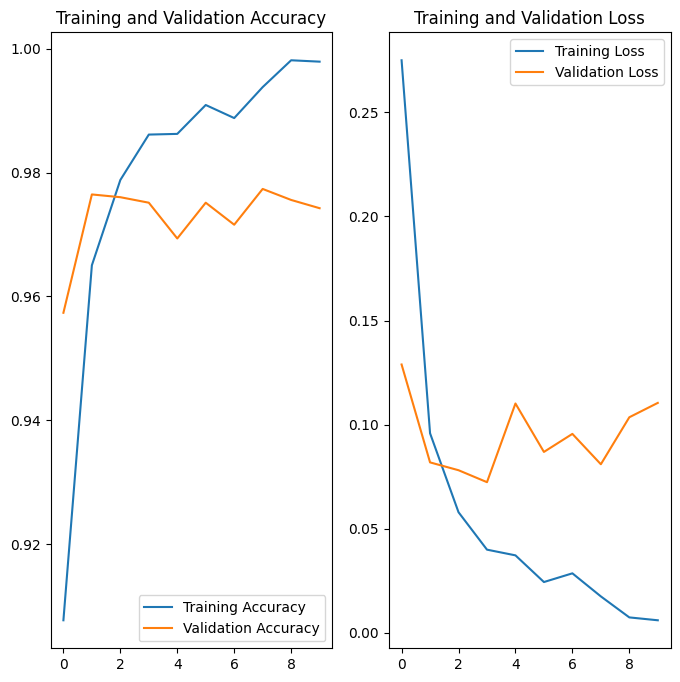

In [69]:
import matplotlib.pyplot as plt

acc = tomato_history.history['accuracy']
val_acc = tomato_history.history['val_accuracy']

loss = tomato_history.history['loss']
val_loss = tomato_history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [70]:
from keras.preprocessing import image
# 로컬 이미지 경로 설정
local_image_path = "./test-case/healthy_tomato.png"

# 이미지 불러오기
img = image.load_img(local_image_path, target_size=(height, width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가

# 모델 예측
predictions = tomato_dnn_model.predict(img_array)


# 클래스 이름과 신뢰도 출력
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(tomato_class_names[np.argmax(predictions)], 100 * np.max(predictions))
)

NameError: name 'tomato_dnn_model' is not defined